# Time Series Decomposition

A time series is a sequence of observations recorded at regular time intervals. The frequency can be anything: minutely, daily, monthly, quarterly, and so on.

Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests, kpss, pacf

### Let's first visualize our data set.

For this example, we are looking at Apple Inc. (NYSE: AAPL) and its (split and dividend adjusted) monthly closing prices since December 31st, 1999 to October 12th, 2020.

In [17]:
# Read data from file.
df = pd.read_csv('./../data/clean/aapl-daily-compact.csv', parse_dates=['timestamp'], index_col=['timestamp'])
df.head()

,open,high,low,close,volume
timestamp,,,,,
2020-05-22,315.77,319.23,315.35,318.89,20450754
2020-05-26,323.50,324.24,316.50,316.73,31380454
2020-05-27,316.14,318.71,313.09,318.11,28236274
2020-05-28,316.77,323.44,315.63,318.25,33449103
2020-05-29,319.25,321.15,316.47,317.94,38399532


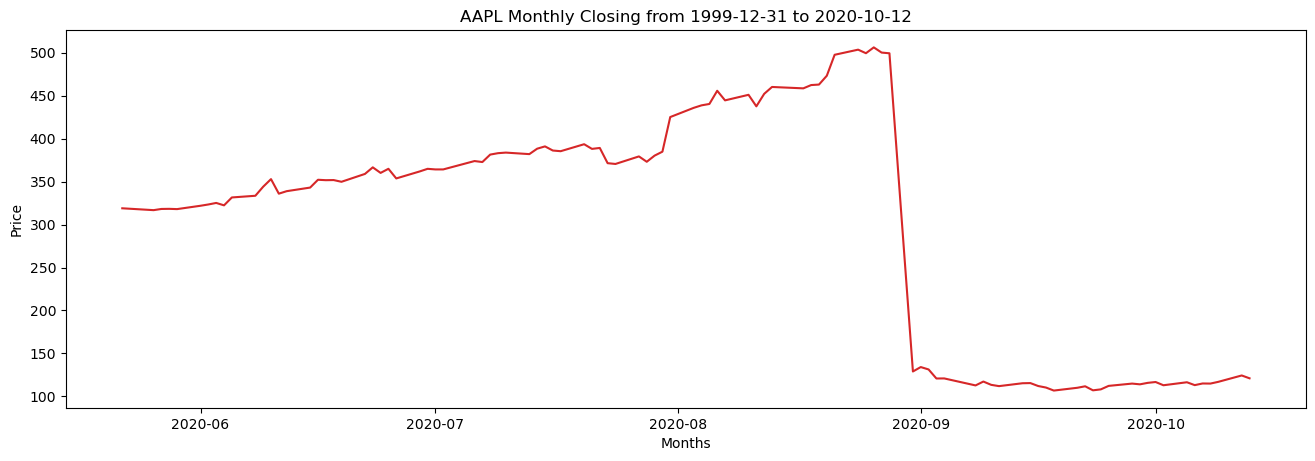

In [18]:
# Visualize the original series.
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.index, df['close'], color='tab:red')

plt.gca().set(title='AAPL Monthly Closing from 1999-12-31 to 2020-10-12', xlabel='Months', ylabel='Price')

plt.show()

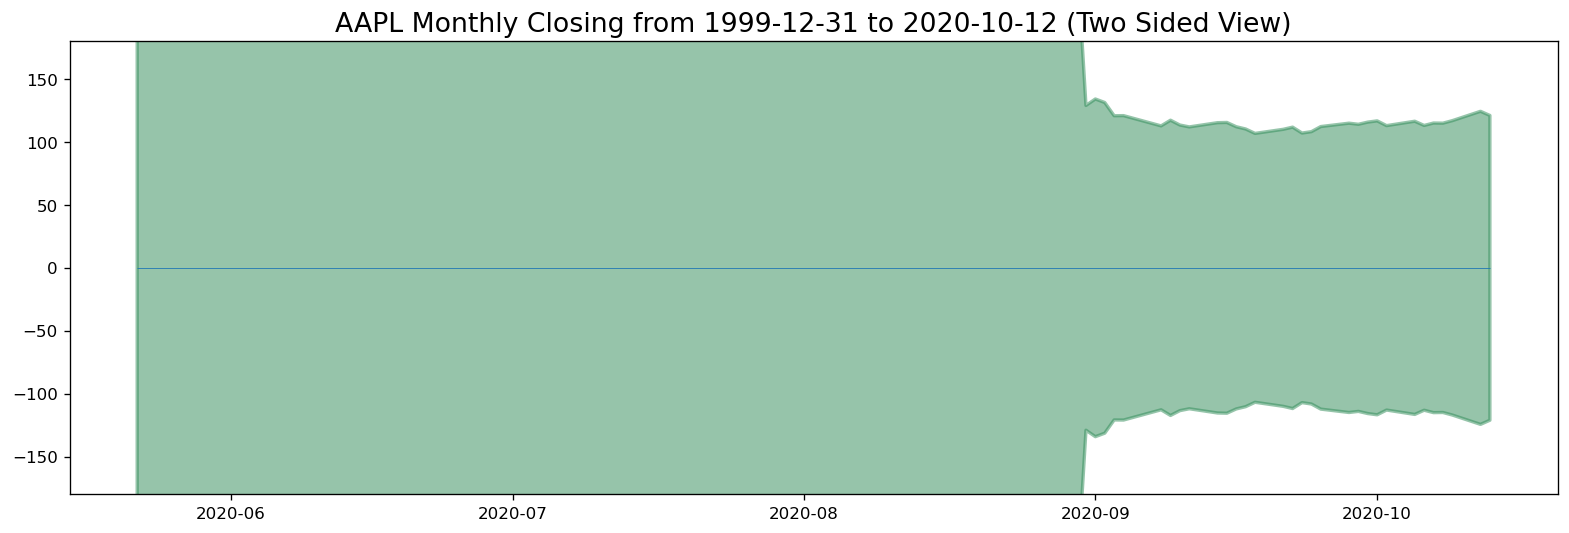

In [19]:
# Since all values are positive, we can plot a two-sided view to emphasize growth.
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)

plt.fill_between(df.index, y1=df['close'], y2=-df['close'], alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-180, 180)
plt.title('AAPL Monthly Closing from 1999-12-31 to 2020-10-12 (Two Sided View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)

plt.show()

In [20]:
# Parse the index into readable time values.
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
df.head()

,open,high,low,close,volume,year,month
timestamp,,,,,,,
2020-05-22,315.77,319.23,315.35,318.89,20450754,2020,May
2020-05-26,323.50,324.24,316.50,316.73,31380454,2020,May
2020-05-27,316.14,318.71,313.09,318.11,28236274,2020,May
2020-05-28,316.77,323.44,315.63,318.25,33449103,2020,May
2020-05-29,319.25,321.15,316.47,317.94,38399532,2020,May


In [26]:
# Get the unique months that appear in our data set.
months = df['month'].unique()

In [27]:
# Prepare a color palette.
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(months), replace=False)
mycolors

array(['xkcd:vivid purple', 'xkcd:bright lavender', 'xkcd:sapphire',
       'xkcd:dark fuchsia', 'xkcd:dusky pink', 'xkcd:dusty purple'],
      dtype='<U31')

### Visualizing seasonality

The first thing we should be doing is to look for any easy wins by arranging the data into something the human eye can easily intuit. We can stack every year's closing prices on top of each other and index by months to see if any trends appear at the monthly level.

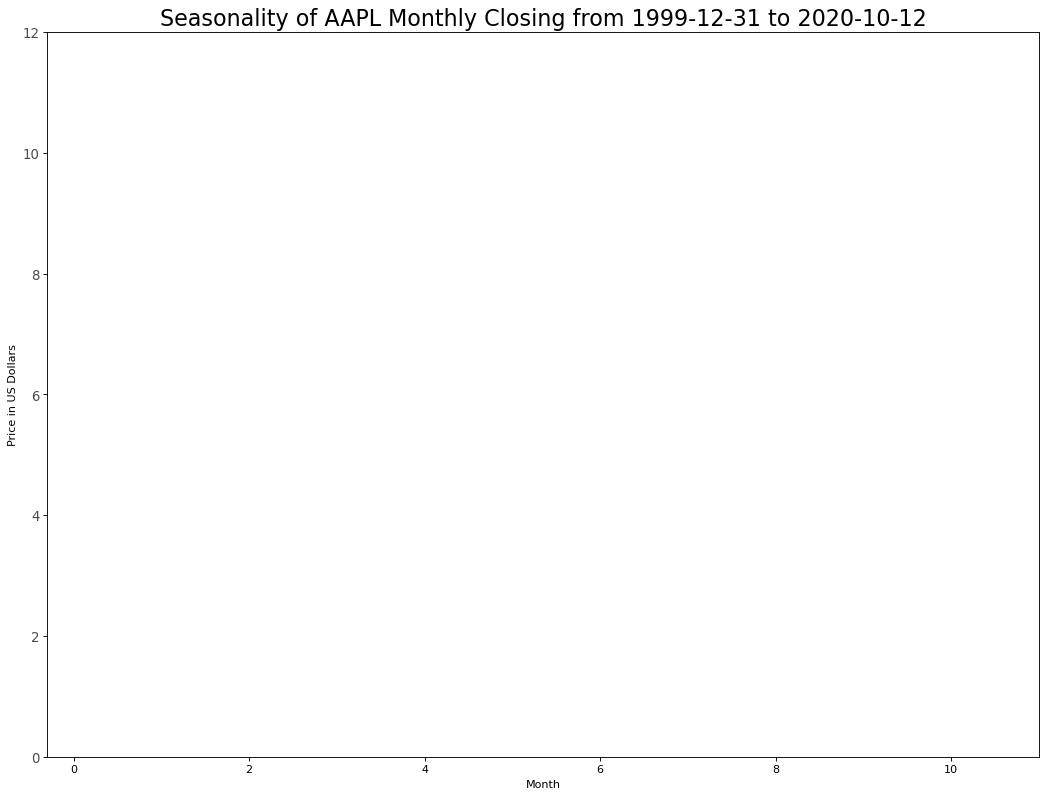

In [28]:
# Draw plot.
plt.figure(figsize=(16,12), dpi= 80)

for i, y in enumerate(years):
    if i > 0 and i < 12:
        plt.plot('month', 'close', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'close'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        
plt.gca().set(xlim=(-0.3, 11), ylim=(0, 12), ylabel='Price in US Dollars', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonality of AAPL Monthly Closing from 1999-12-31 to 2020-10-12", fontsize=20)
plt.show()

### Seasonal decomposition

Any time series can be split into a few main components:

$base + trend + seasonality + error$

A trend is observed when there is an increasing or decreasing slope in the data. A seasonality is observed when there is a distinct repeated pattern observed at regular intervals. 

Keep in mind, however, that a time series is not required to have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

There are two main forms of seasonality:

Additive: $value = base + trend + seasonality + error$

Multiplicative: $value = base * trend * seasonality * error$

We will be performing a battery of tests to figure out which is more appropriate for our data set.

In [ ]:
# Multiplicative decomposition.
multi_dc = seasonal_decompose(df['adjusted close'], model='multiplicative', period=12, extrapolate_trend='freq')

In [ ]:
# Additive decomposition.
add_dc = seasonal_decompose(df['adjusted close'], model='additive', period=12, extrapolate_trend='freq')

In [ ]:
# Plot seasonal decomposition.
plt.rcParams.update({'figure.figsize': (10,10)})
multi_dc.plot().suptitle('Multiplicative Decomposition', fontsize=22)
add_dc.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

Looking at the residuals of additive decomposition, there seems to be some repeating pattern left over. The residuals of multiplicative decomposition, however, looks quite random, which is good. So ideally, Hence, we will be preferring multiplicative decomposition for our particular use case.

In [ ]:
# Extract decomposition components.
df_reconstructed = pd.concat([multi_dc.seasonal, multi_dc.trend, multi_dc.resid, multi_dc.observed], axis=1)
df_reconstructed.columns = ['Seasonal', 'Trend', 'Residual', 'Actual']
df_reconstructed.head()

### Checking stationarity before we continue.

Before we can get any further, we'll need to examine our data set for stationarity. Stationarity is a property of a time series where the values of the series is not a function of time. That is, the statistical properties of the series (i.e. mean, variance, autocorrelation, etc.) are constant over time.

A stationary time series is devoid of seasonal effects.

We have a few methods to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called unit root tests.

The most commonly used is the Augmented Dickey-Fuller test, where the null hypothesis is the time series possesses a unit root and is non-stationary. If the p-valueis less than the significance level (0.05), you reject the null hypothesis.

The Kwiatkowski-Phillips-Schmidt-Shin test, however, is used to test for trend stationarity. The null hypothesis and the p-balue interpretation is just the opposite of Augmented Dickey-Fuller.

In [ ]:
# Augmented Dickey-Fuller test.
adf = adfuller(df_reconstructed['Actual'].values, autolag='AIC')

print('ADF statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))

print('Critical values:')

for key, value in adf[4].items():
    print('    {}, {}'.format(key, value))

In [ ]:
# Kwiatkowski-Phillips-Schmidt-Shin test.
kp = kpss(df_reconstructed['Actual'].values, regression='c', nlags='auto')

print('KPSS statistic: {}'.format(kp[0]))
print('p-value: {}'.format(kp[1]))

print('Critical values:')

for key, value in kp[3].items():
    print('    {}, {}'.format(key, value))

We can actually make a series stationary with some clever magic. The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. If the first difference doesn’t make a series stationary, you can go for the second differencing.

You can differentiate as many times as you like.

In [ ]:
# De-trend by differencing the line of best fit, determined by least squares.
detrend_ls = signal.detrend(df_reconstructed['Actual'].values)
detrend_ls[:5]

In [ ]:
# Draw the plot.
plt.plot(detrend_ls)
plt.title('AAPL Monthly Closing Detrended by Differencing Least Squares', fontsize=16)

In [ ]:
# De-trend by differencing the trend component.
detrend_multi = df_reconstructed['Actual'].values / df_reconstructed['Trend'].values
detrend_multi[:5]

In [ ]:
# Draw the plot.
plt.plot(detrend_multi)
plt.title('AAPL Monthly Closing Detrended by Differencing Trend Component', fontsize=16)

In [ ]:
# De-seasonalize by differencing the seasonal component.
deseason = df_reconstructed['Actual'].values / df_reconstructed['Seasonal'].values
deseason[:5]

In [ ]:
# Draw the plot.
plt.plot(deseason)
plt.title('AAPL Monthly Closing Deseasonalized by Differencing Seasonal Component', fontsize=16)

### Using auto-correlation.

A common way of testing for seasonality in a time series is to plot the series and check for repeated patterns in fixed time intervals.

However, a more definitive inspection of seasonality can be done by using the auto-correlation function (ACF) plot.

It should be noted, though, that strong patterns in data sets are often distorted by virtually any noise.

In [ ]:
# Draw the auto-correlation plot.
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df_reconstructed['Actual'].values.tolist())

### Using partial auto-correlation.

Auto-correlation is simply the correlation of a time series with its own lag. Partial auto-correlation conveys similar information, showing the pure correlation of a series with its lag, excluding the contributions from intermediate lag. 

In [ ]:
# Draw the auto-correlation function and partial auto-correlation function plots.
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_reconstructed['Actual'].tolist(), lags=50, ax=axes[0])
plot_pacf(df_reconstructed['Actual'].tolist(), lags=50, ax=axes[1])

In [ ]:
# Set up the lag plot.
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df_reconstructed['Actual'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of AAPL Monthly Closing \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

# fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
# for i, ax in enumerate(axes.flatten()[:4]):
#     lag_plot(<ALTERNATIVE_DATA_SET>.value, lag=i+1, ax=ax, c='firebrick')
#     ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of AAPL Monthly Closing', y=1.05)    
plt.show()

### Estimating forecastability.

The more regular and repeated patterns a time series has, the easier it is to forecast. Approximate entropy can be used to quantify the regularity and unpredictability of fluctuations over time. The higher the approximate entropy, the more difficult it is to forecast it.

In [ ]:
# Set up the entropy functions.
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

In [ ]:
# Define the approximate entropy function.
def ApproximateEntropy(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

In [ ]:
# Print the results of approximate entropy.
print('Actual: {}'.format(ApproximateEntropy(df_reconstructed['Actual'], m=2, r=0.2*np.std(df_reconstructed['Actual']))))
print('Random small number: {}'.format(ApproximateEntropy(rand_small, m=2, r=0.2*np.std(rand_small))))
print('Random big number: {}'.format(ApproximateEntropy(rand_big, m=2, r=0.2*np.std(rand_big))))

An alternative to approximate entropy is sample entropy, which can be more consistent in estimate complexity even for smaller data sets.

In [ ]:
# Define the sample entropy function.
def SampleEntropy(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

In [ ]:
# Print the results of sample entropy.
print('Actual: {}'.format(SampleEntropy(df_reconstructed['Actual'], m=2, r=0.2*np.std(df_reconstructed['Actual']))))
print('Random small number: {}'.format(SampleEntropy(rand_small, m=2, r=0.2*np.std(rand_small))))
print('Random big number: {}'.format(SampleEntropy(rand_big, m=2, r=0.2*np.std(rand_big))))

### Smoothening a time series.

Smoothening a time series out may be useful in reducing the noise in a signal and get a more fair approximation of a noise-filtered time series. The smoothened version can also be used as a feature to explain the original series itself. Finally, it can be used to visualize the underlying better.

We can smoothen the data using the following methods:

* Taking a moving average.
* Using localized regression.
* Using locally weighted regression.

In [ ]:
# Get the moving average for LOWESS.
df_ma = df_reconstructed['Actual'].rolling(3, center=True, closed='both').mean()
df_ma.head()

In [ ]:
# LOWESS smoothing at 5%.
df_lowess_5 = pd.DataFrame(lowess(df_reconstructed['Actual'], np.arange(len(df_reconstructed['Actual'])), frac=0.05)[:, 1], index=df_reconstructed['Actual'].index, columns=['value'])
df_lowess_5.head()

In [ ]:
# LOWESS smoothing at 5%.
df_lowess_15 = pd.DataFrame(lowess(df_reconstructed['Actual'], np.arange(len(df_reconstructed['Actual'])), frac=0.15)[:, 1], index=df_reconstructed['Actual'].index, columns=['value'])
df_lowess_15.head()

In [ ]:
# Plot the LOWESS-smoothened data set.
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)

df_reconstructed['Actual'].plot(ax=axes[0], color='k', title='Original')

df_lowess_5['value'].plot(ax=axes[1], title='LOWESS 5%')
df_lowess_15['value'].plot(ax=axes[2], title='LOWESS 15%')

df_ma.plot(ax=axes[3], title='Moving Average (3)')

fig.suptitle('Smoothened AAPL Monthly Closing Prices', y=0.95, fontsize=14)
plt.show()

### How to tell if a time series is helpful in forecasting another.

We can use the Granger causality test to solve this problem. The test is based on the idea that if $X$ causes $Y$, then the forecast of $Y$ and the previous values of $X$ should outperform the forecast of $Y$ based on the previous values of $Y$ alone.

The Granger causality test should not be used to test if a lag of $Y$ causes $Y$; instead, it is generally used on exogenous variables only.

If the p-values are less than a significance level, then we can safely reject the null hypothesis and conclude that the lag of $X$ does indeed have predictive power.

In [ ]:
# Run the Granger causality test.
df_reconstructed['Month'] = [d.month for d in df_reconstructed.index]
grangercausalitytests(df_reconstructed[['Actual', 'Month']], maxlag=2)